In [213]:
import os

import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [214]:
num_classes = 9

train_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/train"),
    image_size=(128, 128),
    batch_size=256
)

validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/val"),
    image_size=(128, 128),
    batch_size=256
)

test_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/test"),
    image_size=(128, 128),
    batch_size=256
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 6802 files belonging to 9 classes.
Found 1419 files belonging to 9 classes.
Found 1555 files belonging to 9 classes.


In [215]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

all_labels = []
for _, labels in train_dataset.unbatch():
    all_labels.append(labels.numpy())

all_labels = np.array(all_labels)

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class Weights:", class_weights)

def sparse_categorical_focal_loss_with_class_weights(class_weights, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])

        # Gather class weights for each sample
        weights = tf.gather(tf.constant([class_weights[i] for i in range(len(class_weights))]), y_true)

        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred)
        probs = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        focal_factor = tf.pow(1.0 - probs, gamma)

        # Apply both focal loss and class weight
        return weights * focal_factor * cross_entropy
    return loss

Class Weights: {0: 0.3505462791177077, 1: 0.9183205076279195, 2: 0.7116551579828416, 3: 1.078142336344904, 4: 1.5712635712635712, 5: 1.1180144641683103, 6: 1.9085297418630751, 7: 2.7583130575831305, 8: 3.2436814496900332}


In [216]:
model = models.Sequential([
    layers.Input(shape=(48, 48, 3)),
    layers.Rescaling(1./255),
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')
])


model.compile(optimizer='adam',
              loss=sparse_categorical_focal_loss_with_class_weights(class_weights, gamma=2.0),
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(
        patience=5,
        verbose=0,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    ModelCheckpoint(
        filepath="age_CNN.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20 ,
    callbacks=callbacks,
    verbose=1
)

# If we end up using this model, uncomment the next line and run the modeling.
model.save("age_predictor_model.keras")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1185 - loss: 1.7307
Epoch 1: val_loss improved from inf to 1.70894, saving model to age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.1201 - loss: 1.7310 - val_accuracy: 0.2918 - val_loss: 1.7089
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2745 - loss: 1.7240
Epoch 2: val_loss improved from 1.70894 to 1.69292, saving model to age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2736 - loss: 1.7242 - val_accuracy: 0.2812 - val_loss: 1.6929
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2780 - loss: 1.6968
Epoch 3: val_loss improved from 1.69292 to 1.62544, saving model to age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2784 - loss: 1.6965 - val_accuracy: 0.3263 - val_loss: 1.6254
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2537 - loss: 1.6387
Epoch 4: val_loss improved from 1.62544 to 1.56014, saving model to age_CNN.keras

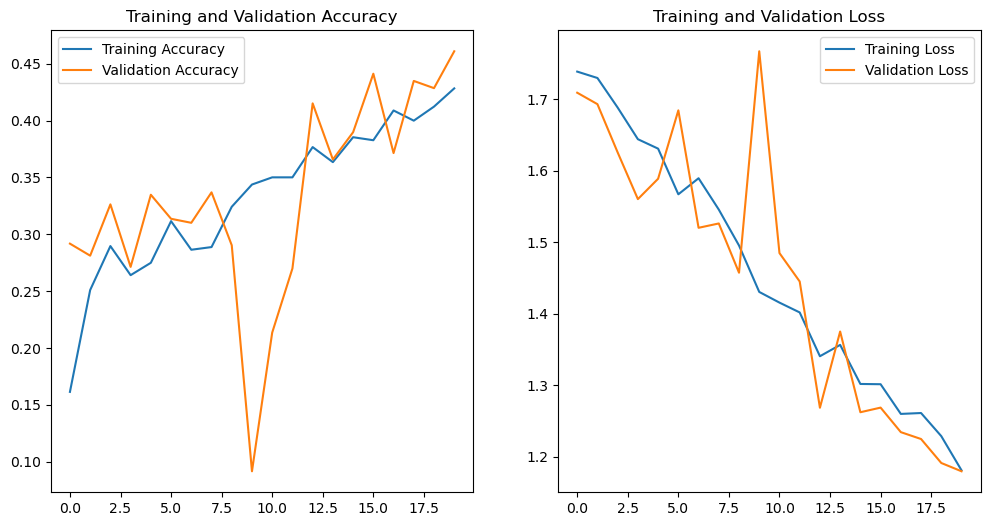

In [217]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


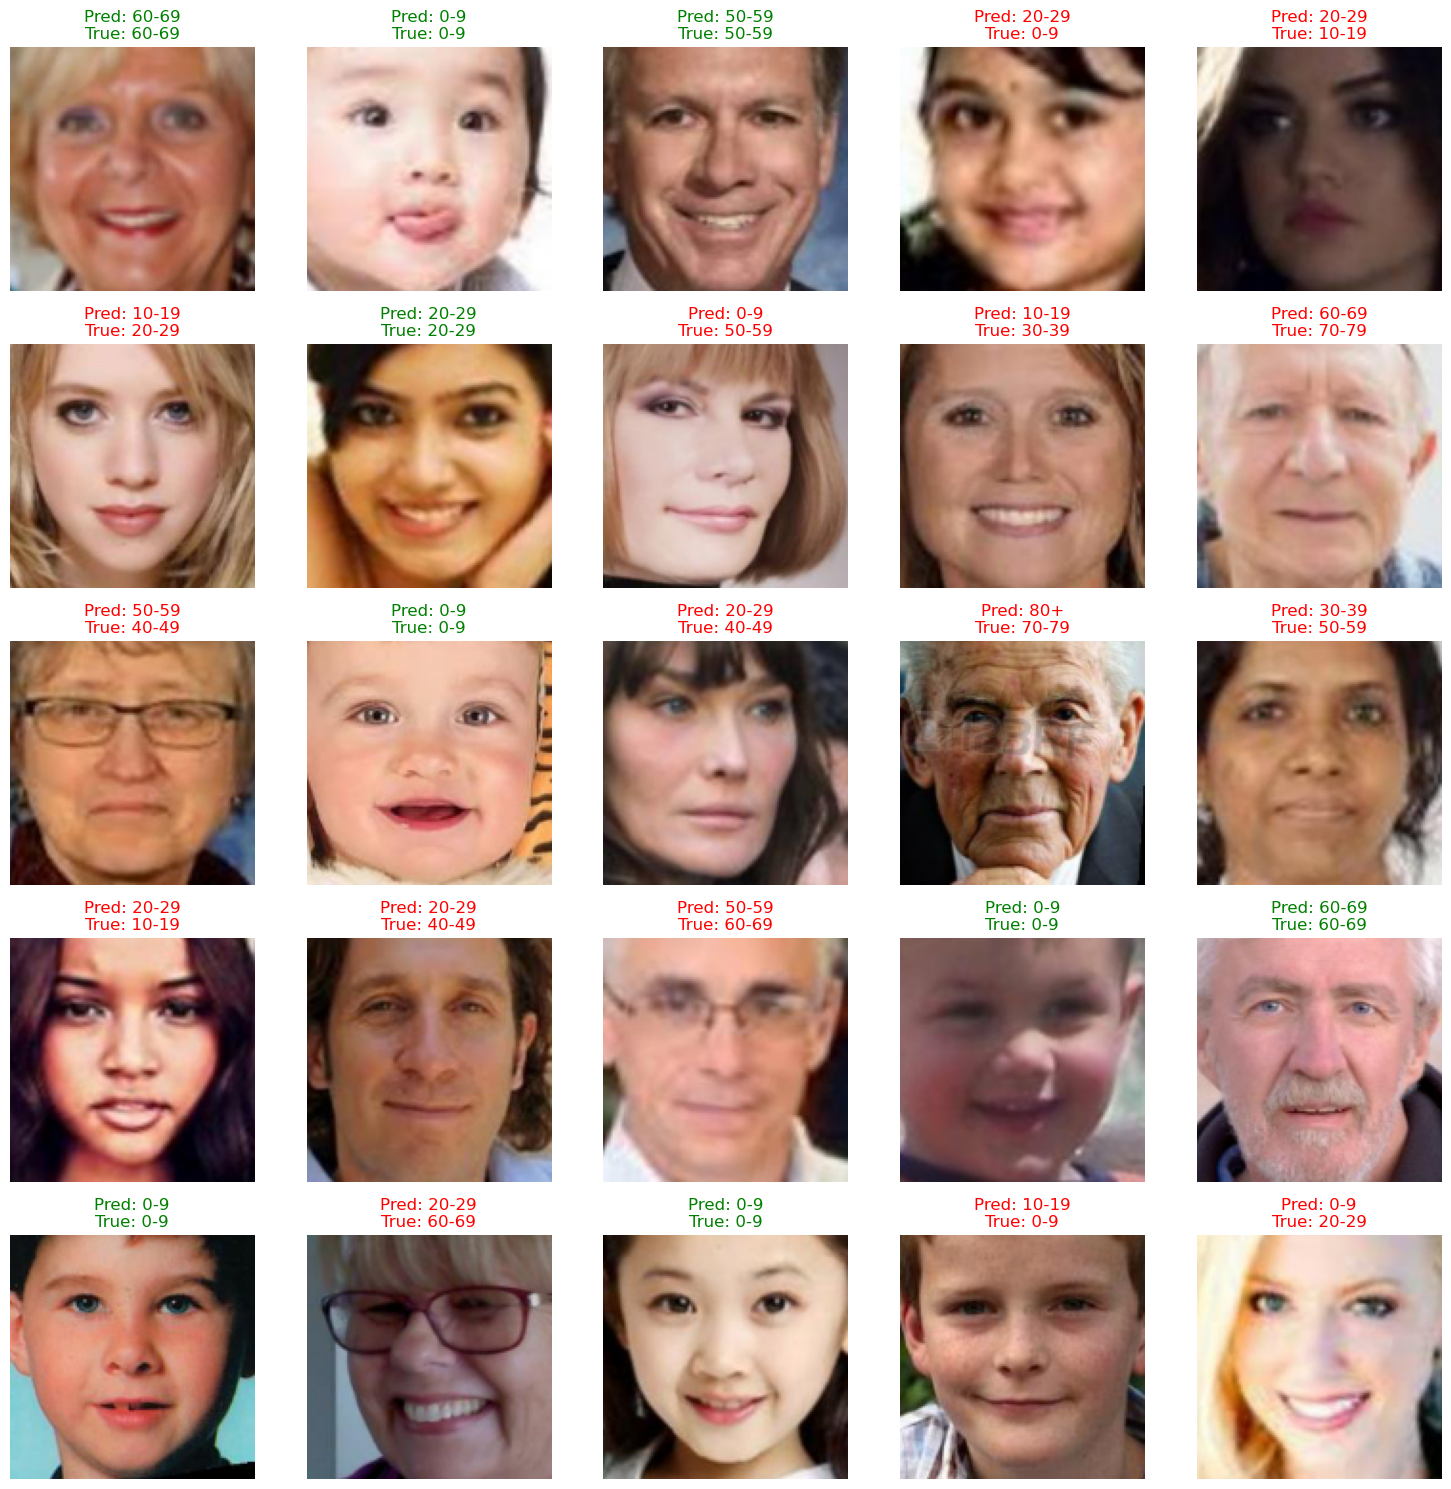

In [218]:
class_names = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]

for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


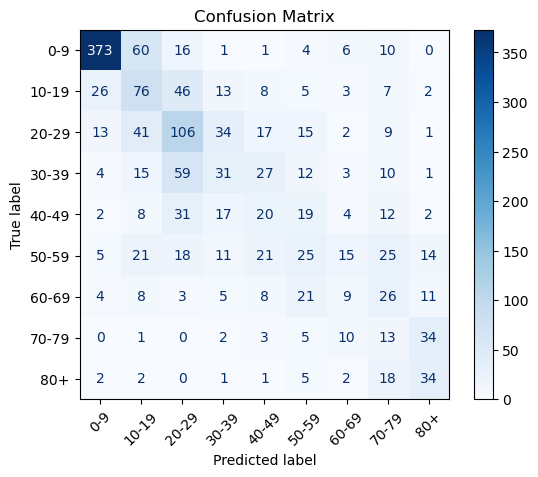

In [219]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
pred_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    pred_labels.extend(tf.argmax(preds, axis=1).numpy())
    true_labels.extend(labels.numpy())

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [220]:
x_test = []
y_test = []

for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

# Combining batches into one large array
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(x_test.shape)
print(y_test.shape)

# Ennustetaan kaikki testikuvat
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Alustetaan oikein
class_correct = [0 for _ in range(len(class_names))]
class_total = [0 for _ in range(len(class_names))]

# Lasketaan tarkkuus joka luokalle
for true_label, pred_label in zip(y_test, y_pred_labels):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

# Tulostetaan tulokset
for i in range(len(class_names)):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Accuracy of %5s : %2d %%' % (class_names[i], accuracy))
    else:
        print('No samples for class', class_names[i])

(1555, 128, 128, 3)
(1555,)
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Accuracy of   0-9 : 79 %
Accuracy of 10-19 : 40 %
Accuracy of 20-29 : 44 %
Accuracy of 30-39 : 19 %
Accuracy of 40-49 : 17 %
Accuracy of 50-59 : 16 %
Accuracy of 60-69 :  9 %
Accuracy of 70-79 : 19 %
Accuracy of   80+ : 52 %
